In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(1435, 15) (410, 15) (178, 15)


## `DataWindow` class 

In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [9]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [10]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [11]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

13/13 [==============================] - 0s 1ms/step - loss: 0.0471 - mean_absolute_error: 0.1392


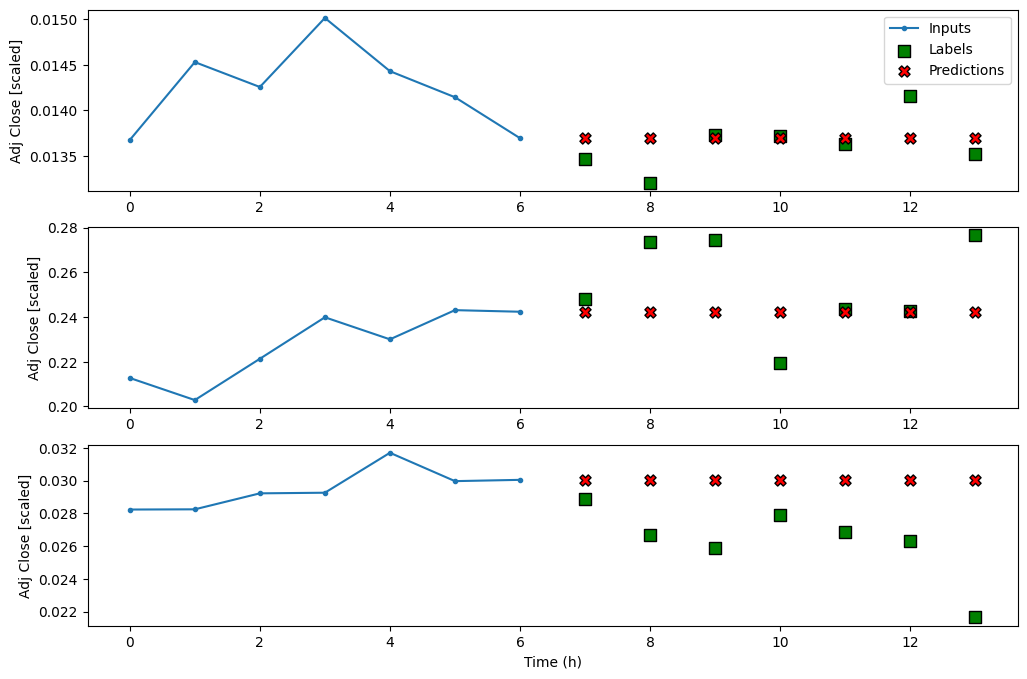

In [12]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [13]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [14]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

13/13 [==============================] - 0s 901us/step - loss: 0.0484 - mean_absolute_error: 0.1458


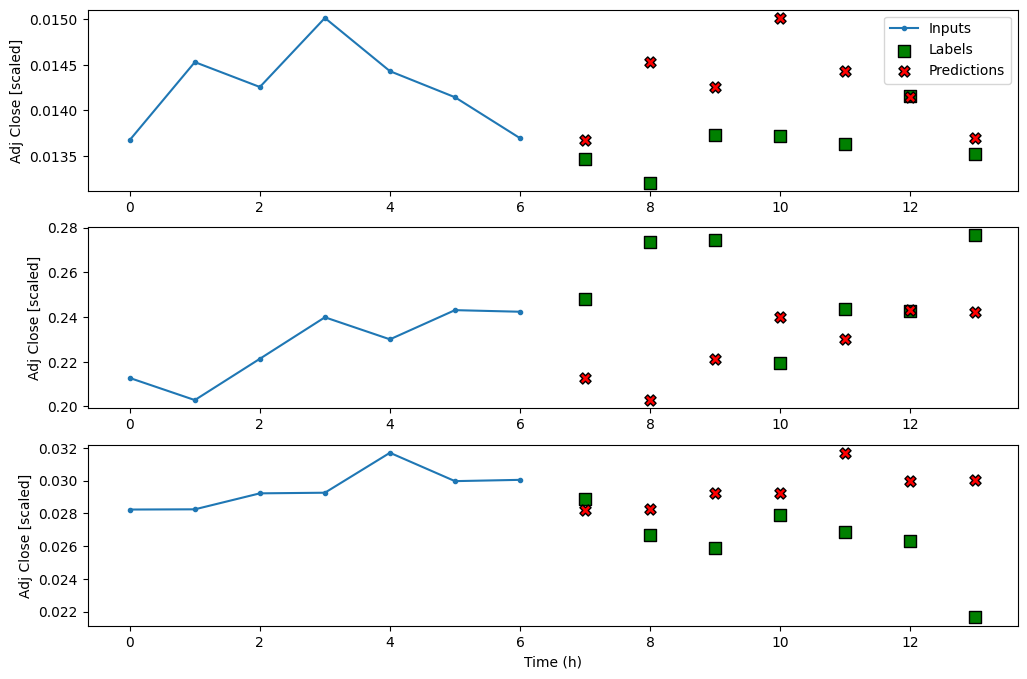

In [15]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [16]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 0s 3ms/step - loss: 0.0359 - mean_absolute_error: 0.1066 - val_loss: 0.0412 - val_mean_absolute_error: 0.1658
Epoch 2/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0102 - mean_absolute_error: 0.0796 - val_loss: 0.0093 - val_mean_absolute_error: 0.0722
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0039 - val_mean_absolute_error: 0.0467
Epoch 4/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0027 - mean_absolute_error: 0.0372 - val_loss: 0.0030 - val_mean_absolute_error: 0.0402
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0280 - val_loss: 0.0034 - val_mean_absolute_error: 0.0437
Epoch 6/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0239 - val_loss: 0.0037 - val_mean_absolute_error: 0.0464
Epoch 7/1000
13/

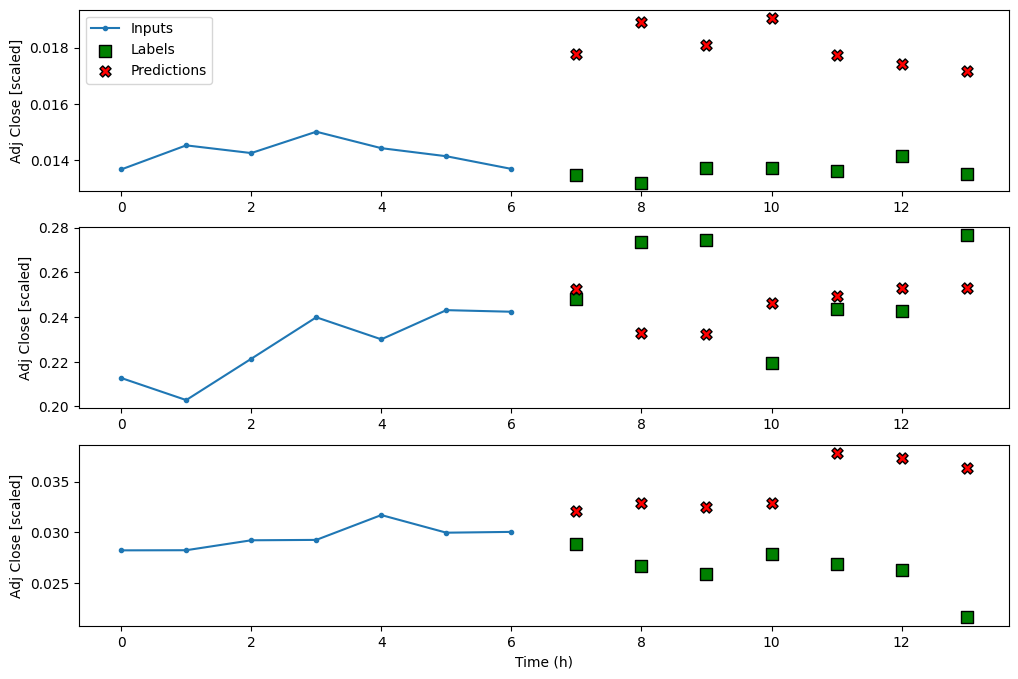

In [17]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [18]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 1s 5ms/step - loss: 0.0238 - mean_absolute_error: 0.0969 - val_loss: 0.0064 - val_mean_absolute_error: 0.0635
Epoch 2/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0270 - val_loss: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0223 - val_loss: 0.0038 - val_mean_absolute_error: 0.0462
Epoch 4/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0211 - val_loss: 0.0074 - val_mean_absolute_error: 0.0674
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0219 - val_loss: 0.0040 - val_mean_absolute_error: 0.0470
Epoch 6/1000
13/13 [==============================] - 0s 976us/step - loss: 0.0039 - mean_absolute_error: 0.0467


## LSTM model 

In [19]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 2s 11ms/step - loss: 0.0342 - mean_absolute_error: 0.1070 - val_loss: 0.0348 - val_mean_absolute_error: 0.1421
Epoch 2/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0450 - val_loss: 0.0149 - val_mean_absolute_error: 0.0875
Epoch 3/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0040 - mean_absolute_error: 0.0348 - val_loss: 0.0109 - val_mean_absolute_error: 0.0817
Epoch 4/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0304 - val_loss: 0.0075 - val_mean_absolute_error: 0.0679
Epoch 5/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0055 - val_mean_absolute_error: 0.0575
Epoch 6/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0238 - val_loss: 0.0052 - val_mean_absolute_error: 0.0560
Epoch 7/1000
45

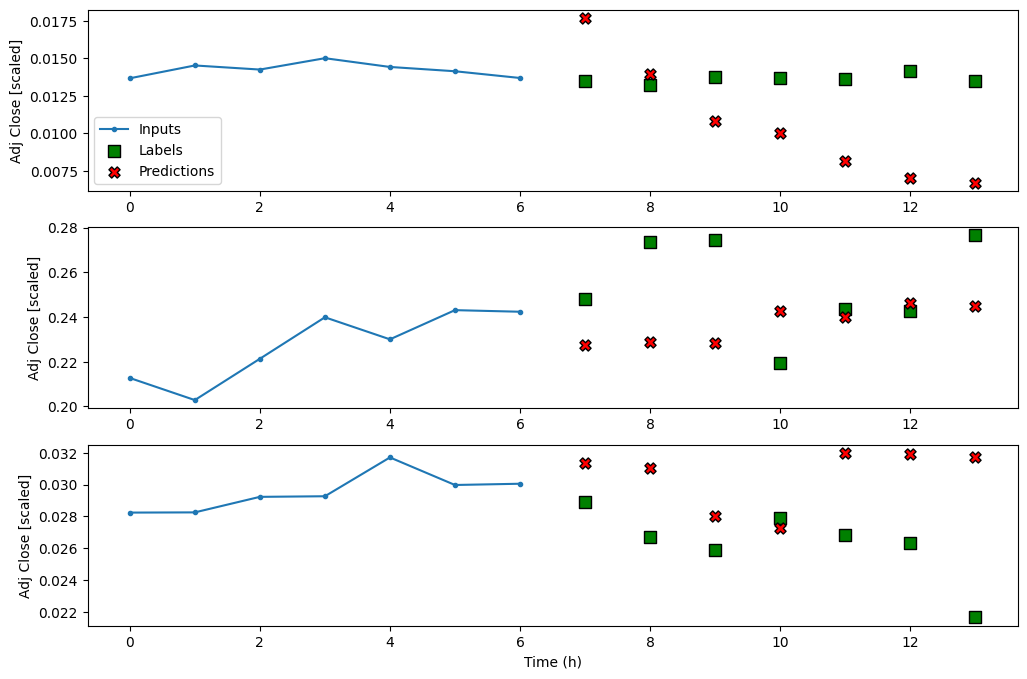

In [20]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [21]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [22]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 1s 4ms/step - loss: 0.0302 - mean_absolute_error: 0.1071 - val_loss: 0.0036 - val_mean_absolute_error: 0.0448
Epoch 2/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_absolute_error: 0.0303 - val_loss: 0.0051 - val_mean_absolute_error: 0.0558
Epoch 3/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0019 - mean_absolute_error: 0.0232 - val_loss: 0.0034 - val_mean_absolute_error: 0.0441
Epoch 4/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0227 - val_loss: 0.0047 - val_mean_absolute_error: 0.0534
Epoch 5/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0219 - val_loss: 0.0042 - val_mean_absolute_error: 0.0496
Epoch 6/1000
45/45 [==============================] - 0s 2ms/step - loss: 0.0017 - mean_absolute_error: 0.0212 - val_loss: 0.0032 - val_mean_absolute_error: 0.0419
Epoch 7/1000
45/

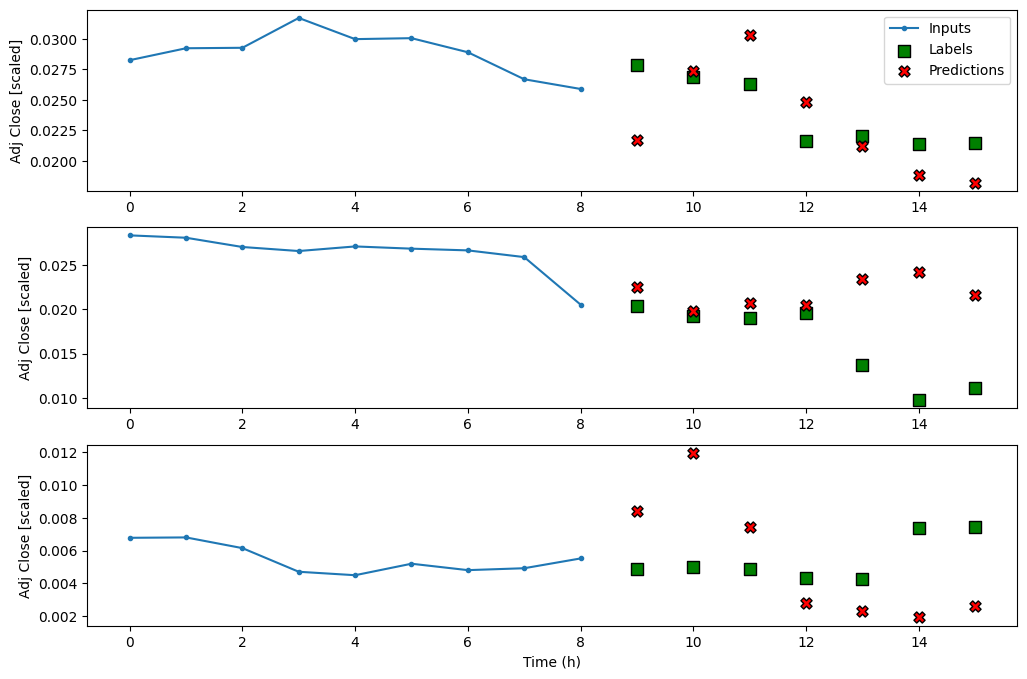

In [23]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [24]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 2s 11ms/step - loss: 0.0312 - mean_absolute_error: 0.1066 - val_loss: 0.0265 - val_mean_absolute_error: 0.1232
Epoch 2/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_absolute_error: 0.0387 - val_loss: 0.0090 - val_mean_absolute_error: 0.0726
Epoch 3/1000
45/45 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0290 - val_loss: 0.0067 - val_mean_absolute_error: 0.0644
Epoch 4/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0263 - val_loss: 0.0080 - val_mean_absolute_error: 0.0716
Epoch 5/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0245 - val_loss: 0.0040 - val_mean_absolute_error: 0.0483
Epoch 6/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0242 - val_loss: 0.0057 - val_mean_absolute_error: 0.0590
Epoch 7/1000
45

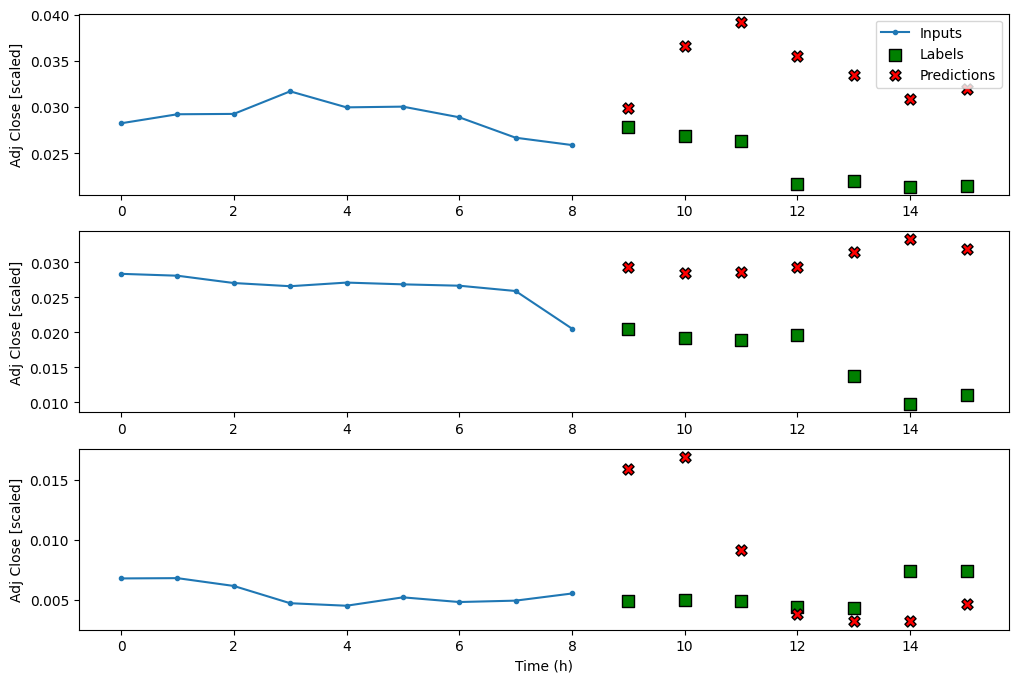

In [25]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [26]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [27]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 2s 10ms/step - loss: 0.0286 - mean_absolute_error: 0.0945 - val_loss: 0.0095 - val_mean_absolute_error: 0.0755
Epoch 2/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0358 - val_loss: 0.0054 - val_mean_absolute_error: 0.0565
Epoch 3/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0284 - val_loss: 0.0042 - val_mean_absolute_error: 0.0490
Epoch 4/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0252 - val_loss: 0.0037 - val_mean_absolute_error: 0.0466
Epoch 5/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0248 - val_loss: 0.0036 - val_mean_absolute_error: 0.0453
Epoch 6/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0049 - val_mean_absolute_error: 0.0519
Epoch 7/1000
45

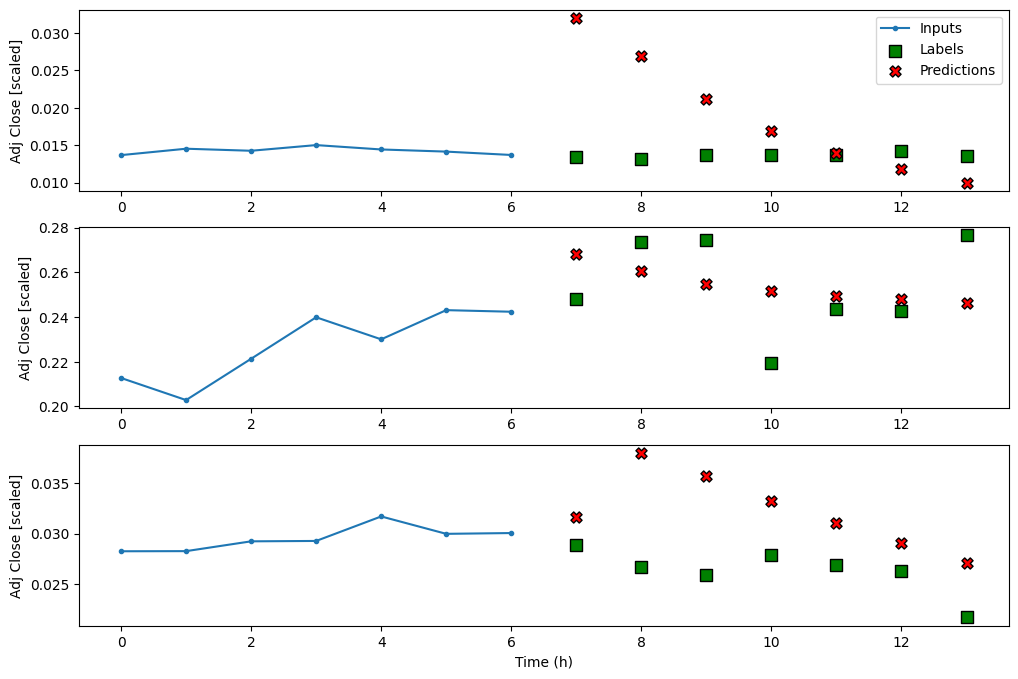

In [28]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [29]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
45/45 [==============================] - 2s 13ms/step - loss: 0.0326 - mean_absolute_error: 0.1087 - val_loss: 0.0256 - val_mean_absolute_error: 0.1201
Epoch 2/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0048 - mean_absolute_error: 0.0360 - val_loss: 0.0074 - val_mean_absolute_error: 0.0671
Epoch 3/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0262 - val_loss: 0.0055 - val_mean_absolute_error: 0.0577
Epoch 4/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0238 - val_loss: 0.0060 - val_mean_absolute_error: 0.0612
Epoch 5/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0223 - val_loss: 0.0038 - val_mean_absolute_error: 0.0464
Epoch 6/1000
45/45 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0223 - val_loss: 0.0092 - val_mean_absolute_error: 0.0781
Epoch 7/1000
45

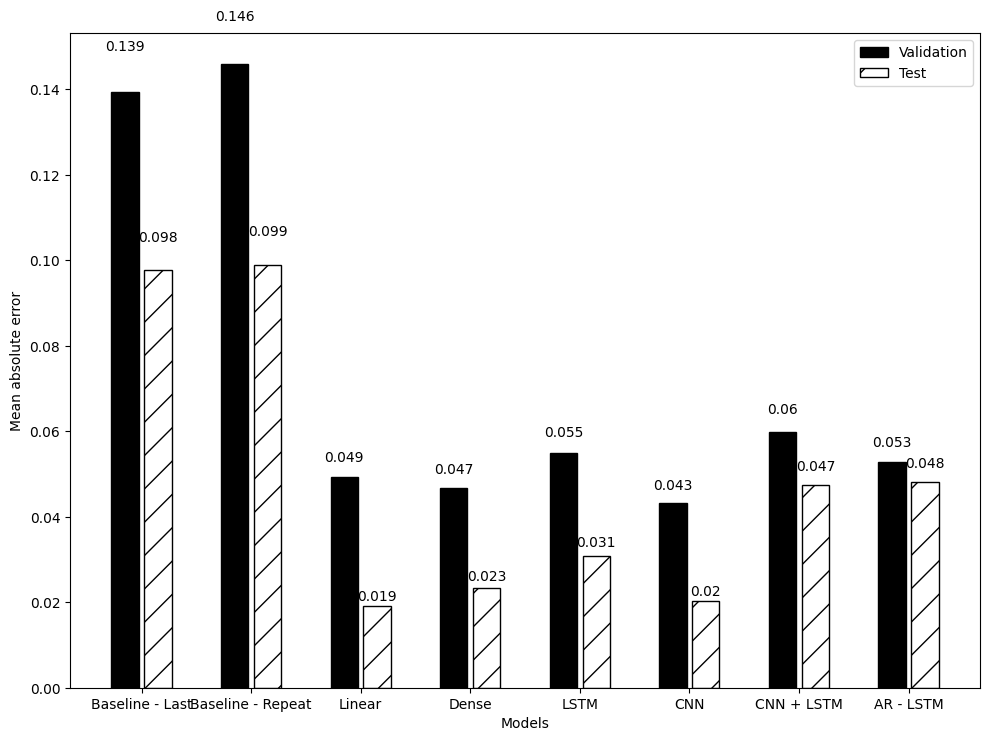

In [33]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+value*0.07, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)